# TCN model

To get simulation data run `./run_sim.sh [small, medium, large, test or custom]` from the `leak_model` directory

Then run `gunzip [file_path]` in your terminal for the output of the sim to turn the gz file into a csv

## Loading data

In [1]:
import pandas as pd
import numpy as np
import math
import qexpy as q
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from darts import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller
from darts.dataprocessing.transformers import Scaler
from darts.models import TCNModel


/opt/anaconda3/envs/WDN_sim/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../output/synthetic_water_data_minute_1000.csv')
df.head()

/var/folders/7y/c70b2kjs6bdfsmfnvfrmypnh0000gn/T/ipykernel_14139/3265498077.py:1: DtypeWarning: Columns (17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../output/synthetic_water_data_minute_1000.csv')


,timestamp,house_id,velocity_m_per_s,flow_m3_s,flow_gpm,upstream_transit_time_s,downstream_transit_time_s,delta_t_ns,pressure_psi,pipe_material,...,l_path_m,pipe_burst_leak,leak_type,leak_category,leak_branch,leak_pipe,c_est_m_per_s,temp_est_c,n_traverses,theta_deg
0,2025-01-01T00:00:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,0.087572,False,none,NaN,NaN,NaN,1447.321655,10.005531,4,60
1,2025-01-01T00:15:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,0.087572,False,none,NaN,NaN,NaN,1447.321655,10.005531,4,60
2,2025-01-01T00:30:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,0.087572,False,none,NaN,NaN,NaN,1447.321655,10.005531,4,60
3,2025-01-01T00:45:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,0.087572,False,none,NaN,NaN,NaN,1447.321655,10.005531,4,60
4,2025-01-01T01:00:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,0.087572,False,none,NaN,NaN,NaN,1447.321655,10.005531,4,60


In [3]:
df.describe()

,house_id,velocity_m_per_s,flow_m3_s,flow_gpm,upstream_transit_time_s,downstream_transit_time_s,delta_t_ns,pressure_psi,pipe_width_in,od_mm,wall_mm,id_mm,l_path_m,c_est_m_per_s,temp_est_c,n_traverses,theta_deg
count,3.505200e+07,3.505200e+07,3.505200e+07,3.505200e+07,3.505200e+07,3.505200e+07,3.505200e+07,3.505200e+07,3.505200e+07,3.505200e+07,3.505200e+07,3.505200e+07,3.505200e+07,3.505200e+07,3.505200e+07,35052000.0,35052000.0
mean,5.005000e+02,2.689800e+00,9.935196e-03,1.574760e+02,7.095707e-05,7.082535e-05,-1.317193e+02,-3.654508e+02,8.807500e-01,2.237105e+01,7.857300e-02,2.221390e+01,1.026016e-01,1.447312e+03,1.000307e+01,4.0,60.0
std,2.886750e+02,2.998266e-01,6.895592e-03,1.092973e+02,1.008047e-05,1.006199e-05,2.369886e+01,7.120368e+02,1.248677e-01,3.171639e+00,3.353200e-02,3.155866e+00,1.457632e-02,9.687937e-03,2.484582e-03,0.0,0.0
min,1.000000e+00,2.400000e+00,3.472000e-03,5.503231e+01,6.023765e-05,6.011292e-05,-1.663720e+02,-9.397137e+03,7.500000e-01,1.905000e+01,4.500000e-02,1.885600e+01,8.709213e-02,1.447301e+03,1.000018e+01,4.0,60.0
25%,2.507500e+02,2.400000e+00,4.690000e-03,7.433801e+01,6.055664e-05,6.045631e-05,-1.663648e+02,-3.506985e+02,7.500000e-01,1.905000e+01,5.000000e-02,1.896000e+01,8.757249e-02,1.447306e+03,1.000140e+01,4.0,60.0
50%,5.005000e+02,2.400000e+00,5.614000e-03,8.898370e+01,8.034450e-05,8.017814e-05,-1.338826e+02,-8.592019e+01,1.000000e+00,2.540000e+01,5.000000e-02,2.515000e+01,1.161629e-01,1.447308e+03,1.000200e+01,4.0,60.0
75%,7.502500e+02,3.000000e+00,1.604400e-02,2.543025e+02,8.080557e-05,8.067168e-05,-1.247317e+02,1.688394e+01,1.000000e+00,2.540000e+01,1.250000e-01,2.530000e+01,1.168557e-01,1.447320e+03,1.000521e+01,4.0,60.0
max,1.000000e+03,3.000000e+00,4.391800e-02,6.961144e+02,8.080730e-05,8.067341e-05,-1.003331e+02,4.539687e+01,1.000000e+00,2.540000e+01,1.250000e-01,2.530000e+01,1.168557e-01,1.447339e+03,1.001011e+01,4.0,60.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35052000 entries, 0 to 35051999
Data columns (total 24 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   timestamp                  object 
 1   house_id                   int64  
 2   velocity_m_per_s           float64
 3   flow_m3_s                  float64
 4   flow_gpm                   float64
 5   upstream_transit_time_s    float64
 6   downstream_transit_time_s  float64
 7   delta_t_ns                 float64
 8   pressure_psi               float64
 9   pipe_material              object 
 10  pipe_width_in              float64
 11  od_mm                      float64
 12  wall_mm                    float64
 13  id_mm                      float64
 14  l_path_m                   float64
 15  pipe_burst_leak            bool   
 16  leak_type                  object 
 17  leak_category              object 
 18  leak_branch                object 
 19  leak_pipe                  object 
 20  

## Leak df

In [5]:
leak_df = df.copy()

In [6]:
leak_df.isnull().sum()

timestamp                           0
house_id                            0
velocity_m_per_s                    0
flow_m3_s                           0
flow_gpm                            0
upstream_transit_time_s             0
downstream_transit_time_s           0
delta_t_ns                          0
pressure_psi                        0
pipe_material                       0
pipe_width_in                       0
od_mm                               0
wall_mm                             0
id_mm                               0
l_path_m                            0
pipe_burst_leak                     0
leak_type                           0
leak_category                30946137
leak_branch                  30946137
leak_pipe                    30946137
c_est_m_per_s                       0
temp_est_c                          0
n_traverses                         0
theta_deg                           0
dtype: int64

In [7]:
nan_cols = ['leak_category','leak_branch','leak_pipe']
leak_df[nan_cols] = leak_df[nan_cols].fillna(value='none')
leak_df.head()

,timestamp,house_id,velocity_m_per_s,flow_m3_s,flow_gpm,upstream_transit_time_s,downstream_transit_time_s,delta_t_ns,pressure_psi,pipe_material,...,l_path_m,pipe_burst_leak,leak_type,leak_category,leak_branch,leak_pipe,c_est_m_per_s,temp_est_c,n_traverses,theta_deg
0,2025-01-01T00:00:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,0.087572,False,none,none,none,none,1447.321655,10.005531,4,60
1,2025-01-01T00:15:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,0.087572,False,none,none,none,none,1447.321655,10.005531,4,60
2,2025-01-01T00:30:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,0.087572,False,none,none,none,none,1447.321655,10.005531,4,60
3,2025-01-01T00:45:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,0.087572,False,none,none,none,none,1447.321655,10.005531,4,60
4,2025-01-01T01:00:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,0.087572,False,none,none,none,none,1447.321655,10.005531,4,60


In [8]:
leak_df.isnull().sum()

timestamp                    0
house_id                     0
velocity_m_per_s             0
flow_m3_s                    0
flow_gpm                     0
upstream_transit_time_s      0
downstream_transit_time_s    0
delta_t_ns                   0
pressure_psi                 0
pipe_material                0
pipe_width_in                0
od_mm                        0
wall_mm                      0
id_mm                        0
l_path_m                     0
pipe_burst_leak              0
leak_type                    0
leak_category                0
leak_branch                  0
leak_pipe                    0
c_est_m_per_s                0
temp_est_c                   0
n_traverses                  0
theta_deg                    0
dtype: int64

## Calculating velocity and flow erros

In [9]:
def calculate_errors(df):
    theta_deg = 60
    theta_cos = np.cos(np.radians(theta_deg))
    epsilon = 1e-10

    # Extract needed fields as arrays
    L = df['l_path_m'].values
    t_u = df['upstream_transit_time_s'].values
    t_d = df['downstream_transit_time_s'].values
    V_actual = df['velocity_m_per_s'].values
    Q_actual = df['flow_m3_s'].values
    id_m = df['id_mm'].values / 1000  # mm to m

    # Step 1: Estimate velocity
    V_est = (L / (2 * theta_cos)) * ((1 / t_d) - (1 / t_u))

    # Step 2: Area of circular pipe
    A = (np.pi/4) * (id_m ** 2)

    # Step 3: Estimate flow
    Q_est = V_est * A

    # Step 4: Error metrics
    velocity_error = np.abs(V_actual - V_est) / np.maximum(np.abs(V_actual), epsilon)
    flow_rate_error = np.abs(Q_actual - Q_est) / np.maximum(np.abs(Q_actual), epsilon)

    # Step 5: Add to DataFrame
    df['V_est'] = V_est
    df['Q_est'] = Q_est
    df['velocity_error'] = velocity_error
    df['flow_rate_error'] = flow_rate_error
    df['velocity_error_pass'] = velocity_error <= 0.05
    df['flow_rate_error_pass'] = flow_rate_error <= 0.05

    return df

In [10]:
# Apply error calculations to the dataframe
calculate_errors(leak_df)

,timestamp,house_id,velocity_m_per_s,flow_m3_s,flow_gpm,upstream_transit_time_s,downstream_transit_time_s,delta_t_ns,pressure_psi,pipe_material,...,c_est_m_per_s,temp_est_c,n_traverses,theta_deg,V_est,Q_est,velocity_error,flow_rate_error,velocity_error_pass,flow_rate_error_pass
0,2025-01-01T00:00:00,1,2.4,0.004760,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,1447.321655,10.005531,4,60,2.4,0.000678,6.494805e-14,0.857646,True,False
1,2025-01-01T00:15:00,1,2.4,0.004760,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,1447.321655,10.005531,4,60,2.4,0.000678,6.494805e-14,0.857646,True,False
2,2025-01-01T00:30:00,1,2.4,0.004760,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,1447.321655,10.005531,4,60,2.4,0.000678,6.494805e-14,0.857646,True,False
3,2025-01-01T00:45:00,1,2.4,0.004760,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,1447.321655,10.005531,4,60,2.4,0.000678,6.494805e-14,0.857646,True,False
4,2025-01-01T01:00:00,1,2.4,0.004760,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,1447.321655,10.005531,4,60,2.4,0.000678,6.494805e-14,0.857646,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35051995,2025-12-31T23:00:00,1000,2.4,0.003962,62.798973,0.000061,0.00006,-100.333635,-50.402031,Copper,...,1447.325928,10.006645,4,60,2.4,0.000678,6.772360e-14,0.828974,True,False
35051996,2025-12-31T23:15:00,1000,2.4,0.003962,62.798973,0.000061,0.00006,-100.333635,-50.402031,Copper,...,1447.325928,10.006645,4,60,2.4,0.000678,6.772360e-14,0.828974,True,False
35051997,2025-12-31T23:30:00,1000,2.4,0.003962,62.798973,0.000061,0.00006,-100.333635,-50.402031,Copper,...,1447.325928,10.006645,4,60,2.4,0.000678,6.772360e-14,0.828974,True,False
35051998,2025-12-31T23:45:00,1000,2.4,0.003962,62.798973,0.000061,0.00006,-100.333635,-50.402031,Copper,...,1447.325928,10.006645,4,60,2.4,0.000678,6.772360e-14,0.828974,True,False


In [11]:
leak_df.columns.tolist()

['timestamp',
 'house_id',
 'velocity_m_per_s',
 'flow_m3_s',
 'flow_gpm',
 'upstream_transit_time_s',
 'downstream_transit_time_s',
 'delta_t_ns',
 'pressure_psi',
 'pipe_material',
 'pipe_width_in',
 'od_mm',
 'wall_mm',
 'id_mm',
 'l_path_m',
 'pipe_burst_leak',
 'leak_type',
 'leak_category',
 'leak_branch',
 'leak_pipe',
 'c_est_m_per_s',
 'temp_est_c',
 'n_traverses',
 'theta_deg',
 'V_est',
 'Q_est',
 'velocity_error',
 'flow_rate_error',
 'velocity_error_pass',
 'flow_rate_error_pass']

In [12]:
leak_df[leak_df['pipe_burst_leak'] == True]['house_id'].nunique()

463

In [13]:
leak_df[leak_df['pipe_burst_leak'] == True]['leak_pipe'].unique()

array(['P_ENS_SHWR', 'P_MAIN_1', 'P_FAM_TUB', 'P_DISHWASHER', 'P_ENS_WC',
       'P_KITCHEN_BRANCH', 'P_WATER_HEATER', 'P_POWDER_LAV', 'P_FAM_LAV',
       'P_LAUNDRY', 'P_HOSE_FRONT', 'P_POWDER_BRANCH', 'P_POWDER_WC',
       'P_ENS_LAV', 'P_MAIN_2', 'P_UPPER_BRANCH', 'P_KITCHEN_SINK',
       'P_HOSE_BACK', 'P_FAM_WC'], dtype=object)

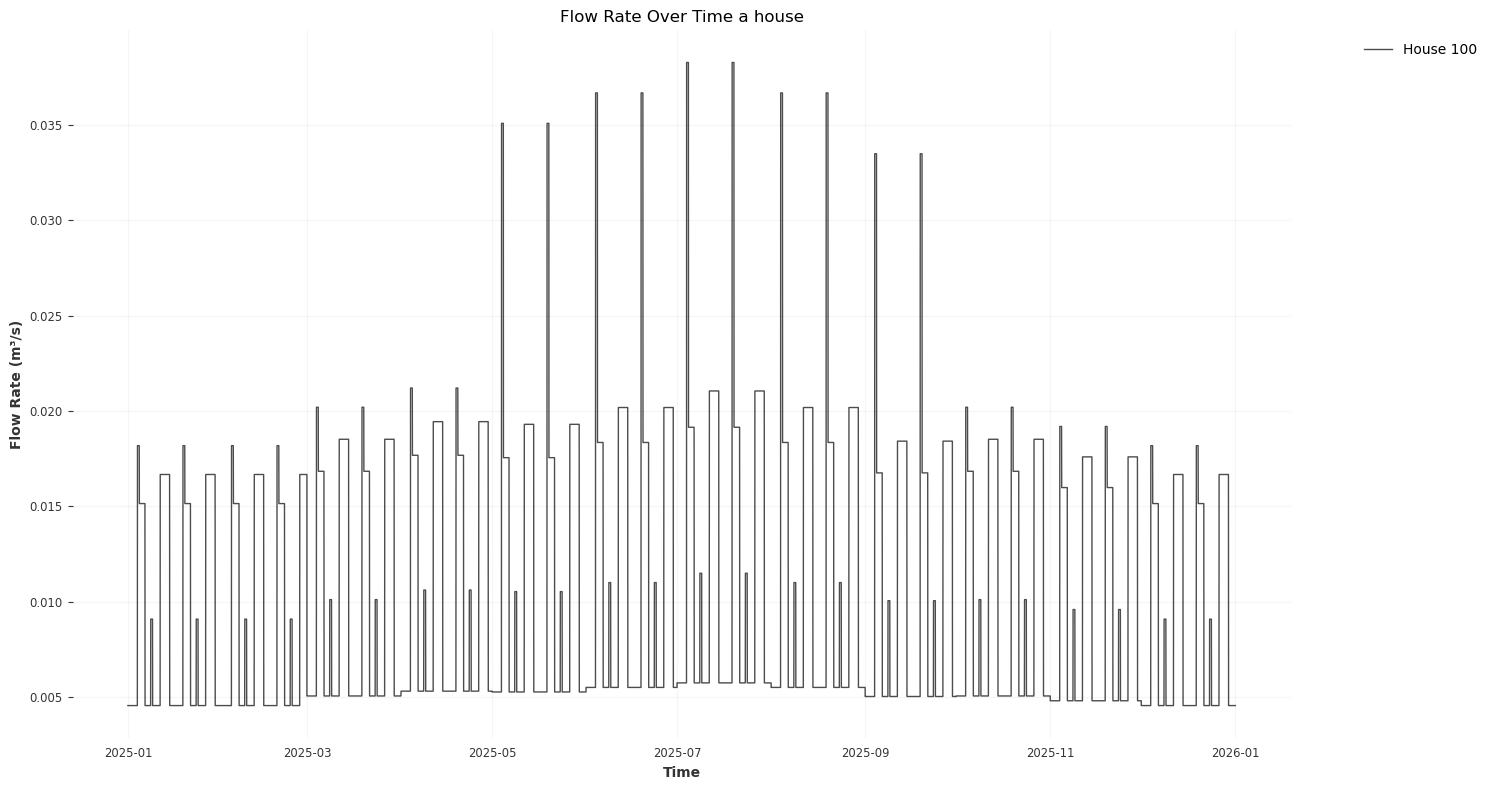

Selected house IDs: [100]


In [14]:
houses = [100]

# Create the plot
plt.figure(figsize=(15, 8))

# Plot flow data for each random house
for house_id in houses:
    house_data = leak_df[leak_df['house_id'] == house_id].copy()
    house_data['timestamp'] = pd.to_datetime(house_data['timestamp'])
    house_data = house_data.sort_values('timestamp')
    
    plt.plot(house_data['timestamp'], house_data['flow_m3_s'], 
             label=f'House {house_id}', alpha=0.7, linewidth=1)

plt.xlabel('Time')
plt.ylabel('Flow Rate (m³/s)')
plt.title('Flow Rate Over Time a house')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print the selected house IDs
print(f"Selected house IDs: {sorted(houses)}")

# TCN development

In [15]:
feat_eng_df = leak_df.copy()

In [16]:
# Defining features and targets
NUMERICAL_FEATURES_v1 = [
    'velocity_m_per_s', 'flow_m3_s', 'upstream_transit_time_s', 
    'downstream_transit_time_s', 'delta_t_ns', 'pipe_width_in',
    'od_mm', 'wall_mm', 'id_mm', 'c_est_m_per_s', 'temp_est_c'
]

CATEGORICAL_FEATURES_v1 = [
    'pipe_material', 'leak_type', 'leak_category', 'leak_pipe'
]

TARGET_COLUMNS = ['pipe_burst_leak', 'leak_branch']

In [17]:
missing_numerical = [col for col in NUMERICAL_FEATURES_v1 if col not in feat_eng_df.columns]
missing_categorical = [col for col in CATEGORICAL_FEATURES_v1 if col not in feat_eng_df.columns]
missing_targets = [col for col in TARGET_COLUMNS if col not in feat_eng_df.columns]

if missing_numerical:
    print(f"Missing numerical features: {missing_numerical}")
if missing_categorical:
    print(f"Missing categorical features: {missing_categorical}")
if missing_targets:
    print(f"Missing target columns: {missing_targets}")

### One-hot encoding

In [18]:
def create_feature_encodings(df):
    """Create one-hot encodings for categorical features"""
    df_encoded = df.copy()
    
    # One-hot encode categorical features
    for cat_feature in CATEGORICAL_FEATURES_v1:
        if cat_feature in df_encoded.columns:
            # Get unique values
            unique_vals = df_encoded[cat_feature].unique()
            print(f"{cat_feature} unique values: {unique_vals}")
            
            # Create one-hot encoding
            encoded_cols = pd.get_dummies(df_encoded[cat_feature], 
                                        prefix=f'{cat_feature}_onehot', 
                                        prefix_sep='_')
            
            # Add encoded columns to dataframe
            df_encoded = pd.concat([df_encoded, encoded_cols], axis=1)
            
            print(f"Created {len(encoded_cols.columns)} columns for {cat_feature}")
    
    return df_encoded

In [19]:
feat_eng_df = create_feature_encodings(feat_eng_df)
feat_eng_df.head()

pipe_material unique values: ['Copper' 'PEX']
Created 2 columns for pipe_material
leak_type unique values: ['none' 'burst_freeze' 'gradual' 'micro' 'burst_pressure']
Created 5 columns for leak_type
leak_category unique values: ['none' 'shower' 'unknown' 'dish' 'toilet' 'faucet' 'laundry']
Created 7 columns for leak_category
leak_pipe unique values: ['none' 'P_ENS_SHWR' 'P_MAIN_1' 'P_FAM_TUB' 'P_DISHWASHER' 'P_ENS_WC'
 'P_KITCHEN_BRANCH' 'P_WATER_HEATER' 'P_POWDER_LAV' 'P_FAM_LAV'
 'P_LAUNDRY' 'P_HOSE_FRONT' 'P_POWDER_BRANCH' 'P_POWDER_WC' 'P_ENS_LAV'
 'P_MAIN_2' 'P_UPPER_BRANCH' 'P_KITCHEN_SINK' 'P_HOSE_BACK' 'P_FAM_WC']
Created 20 columns for leak_pipe


,timestamp,house_id,velocity_m_per_s,flow_m3_s,flow_gpm,upstream_transit_time_s,downstream_transit_time_s,delta_t_ns,pressure_psi,pipe_material,...,leak_pipe_onehot_P_KITCHEN_SINK,leak_pipe_onehot_P_LAUNDRY,leak_pipe_onehot_P_MAIN_1,leak_pipe_onehot_P_MAIN_2,leak_pipe_onehot_P_POWDER_BRANCH,leak_pipe_onehot_P_POWDER_LAV,leak_pipe_onehot_P_POWDER_WC,leak_pipe_onehot_P_UPPER_BRANCH,leak_pipe_onehot_P_WATER_HEATER,leak_pipe_onehot_none
0,2025-01-01T00:00:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,False,False,False,False,False,False,False,False,False,True
1,2025-01-01T00:15:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,False,False,False,False,False,False,False,False,False,True
2,2025-01-01T00:30:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,False,False,False,False,False,False,False,False,False,True
3,2025-01-01T00:45:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,False,False,False,False,False,False,False,False,False,True
4,2025-01-01T01:00:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,False,False,False,False,False,False,False,False,False,True


In [20]:
def prepare_categorical_targets(df, target_cols):
    """Prepare both binary and categorical targets"""
    df_targets = df.copy()
    
    for target_col in target_cols:
        if target_col in df_targets.columns:
            unique_vals = df_targets[target_col].unique()
            
            if target_col == 'pipe_burst_leak':
                # Binary target - keep as is (boolean/binary)
                print(f"{target_col}: Binary target, keeping as boolean")
                
            elif target_col == 'leak_branch':
                # Categorical target - we have options:
                print(f"{target_col} unique values: {unique_vals}")
                
                # One-hot encode for multi-output
                target_encoded = pd.get_dummies(df_targets[target_col], 
                                              prefix=f'{target_col}_onehot', 
                                              prefix_sep='_')
                df_targets = pd.concat([df_targets, target_encoded], axis=1)
                print(f"One-hot encoded {target_col}: {target_encoded.columns.tolist()}")
    
    return df_targets

In [21]:
feat_eng_df = prepare_categorical_targets(feat_eng_df, TARGET_COLUMNS)
feat_eng_df.head()

pipe_burst_leak: Binary target, keeping as boolean
leak_branch unique values: ['none' 'UPPER_FLOOR_BRANCH' 'unknown' 'KITCHEN_BRANCH' 'MAIN_TRUNK_2'
 'POWDER_ROOM_BRANCH' 'MAIN_TRUNK_1']
One-hot encoded leak_branch: ['leak_branch_onehot_KITCHEN_BRANCH', 'leak_branch_onehot_MAIN_TRUNK_1', 'leak_branch_onehot_MAIN_TRUNK_2', 'leak_branch_onehot_POWDER_ROOM_BRANCH', 'leak_branch_onehot_UPPER_FLOOR_BRANCH', 'leak_branch_onehot_none', 'leak_branch_onehot_unknown']


,timestamp,house_id,velocity_m_per_s,flow_m3_s,flow_gpm,upstream_transit_time_s,downstream_transit_time_s,delta_t_ns,pressure_psi,pipe_material,...,leak_pipe_onehot_P_UPPER_BRANCH,leak_pipe_onehot_P_WATER_HEATER,leak_pipe_onehot_none,leak_branch_onehot_KITCHEN_BRANCH,leak_branch_onehot_MAIN_TRUNK_1,leak_branch_onehot_MAIN_TRUNK_2,leak_branch_onehot_POWDER_ROOM_BRANCH,leak_branch_onehot_UPPER_FLOOR_BRANCH,leak_branch_onehot_none,leak_branch_onehot_unknown
0,2025-01-01T00:00:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,False,False,True,False,False,False,False,False,True,False
1,2025-01-01T00:15:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,False,False,True,False,False,False,False,False,True,False
2,2025-01-01T00:30:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,False,False,True,False,False,False,False,False,True,False
3,2025-01-01T00:45:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,False,False,True,False,False,False,False,False,True,False
4,2025-01-01T01:00:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,False,False,True,False,False,False,False,False,True,False


In [22]:
feat_eng_df.columns.tolist()


['timestamp',
 'house_id',
 'velocity_m_per_s',
 'flow_m3_s',
 'flow_gpm',
 'upstream_transit_time_s',
 'downstream_transit_time_s',
 'delta_t_ns',
 'pressure_psi',
 'pipe_material',
 'pipe_width_in',
 'od_mm',
 'wall_mm',
 'id_mm',
 'l_path_m',
 'pipe_burst_leak',
 'leak_type',
 'leak_category',
 'leak_branch',
 'leak_pipe',
 'c_est_m_per_s',
 'temp_est_c',
 'n_traverses',
 'theta_deg',
 'V_est',
 'Q_est',
 'velocity_error',
 'flow_rate_error',
 'velocity_error_pass',
 'flow_rate_error_pass',
 'pipe_material_onehot_Copper',
 'pipe_material_onehot_PEX',
 'leak_type_onehot_burst_freeze',
 'leak_type_onehot_burst_pressure',
 'leak_type_onehot_gradual',
 'leak_type_onehot_micro',
 'leak_type_onehot_none',
 'leak_category_onehot_dish',
 'leak_category_onehot_faucet',
 'leak_category_onehot_laundry',
 'leak_category_onehot_none',
 'leak_category_onehot_shower',
 'leak_category_onehot_toilet',
 'leak_category_onehot_unknown',
 'leak_pipe_onehot_P_DISHWASHER',
 'leak_pipe_onehot_P_ENS_LAV',
 

### Forward shifting targets

In [23]:
def create_supervised_learning_targets(df, forecast_horizon: int = 96): # 96 15-min sections = 24 hours
    """
    Create supervised learning targets for the TCN model. Currently, this 
    creates a prediction if there will be any leaks in the next 24 hours.
    """
    
    df_with_targets = df.copy()
    df_with_targets["timestamp"] = pd.to_datetime(df_with_targets["timestamp"])
    df_with_targets = df_with_targets.sort_values(["house_id", "timestamp"])
    
    future_targets = []
    
    for house_id in df_with_targets["house_id"].unique():
        house_data = df_with_targets[df_with_targets["house_id"] == house_id].copy()
        
        # Rolling window - predict if leak occurs anywhere in next 24 hours
        house_data["pipe_burst_leak_next_24h"] = (
            house_data["pipe_burst_leak"]
            .rolling(window=forecast_horizon, min_periods=1)
            .max()
            .shift(-forecast_horizon + 1)
            .fillna(False)
            .astype(bool)
        )
        
        onehot_cols = [col for col in house_data.columns if col.startswith("leak_branch_onehot_")]
        
        for col in onehot_cols:
            # Only mark branch as True if leak happens on that specific branch
            leak_on_this_branch = (house_data[col] & house_data["pipe_burst_leak"])
            
            house_data[f"{col}_next_24h"] = (
                leak_on_this_branch
                .rolling(window=forecast_horizon, min_periods=1)
                .max()
                .shift(-forecast_horizon + 1)
                .fillna(False)
                .astype(bool)
            )
        
        # Handle "none" case - True only when no leak predicted at all
        none_flag = f"leak_branch_onehot_none_next_24h"
        if none_flag in house_data.columns:
            house_data[none_flag] = (
                house_data["pipe_burst_leak_next_24h"] == False
            )
        
        future_targets.append(house_data)
    
    return pd.concat(future_targets, axis=0, ignore_index=True).dropna(
        subset=["pipe_burst_leak_next_24h"]
    )

In [24]:
feat_eng_df = create_supervised_learning_targets(feat_eng_df)
feat_eng_df.head()

,timestamp,house_id,velocity_m_per_s,flow_m3_s,flow_gpm,upstream_transit_time_s,downstream_transit_time_s,delta_t_ns,pressure_psi,pipe_material,...,leak_branch_onehot_none,leak_branch_onehot_unknown,pipe_burst_leak_next_24h,leak_branch_onehot_KITCHEN_BRANCH_next_24h,leak_branch_onehot_MAIN_TRUNK_1_next_24h,leak_branch_onehot_MAIN_TRUNK_2_next_24h,leak_branch_onehot_POWDER_ROOM_BRANCH_next_24h,leak_branch_onehot_UPPER_FLOOR_BRANCH_next_24h,leak_branch_onehot_none_next_24h,leak_branch_onehot_unknown_next_24h
0,2025-01-01 00:00:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,True,False,False,False,False,False,False,False,True,False
1,2025-01-01 00:15:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,True,False,False,False,False,False,False,False,True,False
2,2025-01-01 00:30:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,True,False,False,False,False,False,False,False,True,False
3,2025-01-01 00:45:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,True,False,False,False,False,False,False,False,True,False
4,2025-01-01 01:00:00,1,2.4,0.00476,75.447525,0.000061,0.00006,-100.334228,-95.084198,Copper,...,True,False,False,False,False,False,False,False,True,False


In [25]:
feat_eng_df[feat_eng_df['pipe_burst_leak_next_24h'] == True]

,timestamp,house_id,velocity_m_per_s,flow_m3_s,flow_gpm,upstream_transit_time_s,downstream_transit_time_s,delta_t_ns,pressure_psi,pipe_material,...,leak_branch_onehot_none,leak_branch_onehot_unknown,pipe_burst_leak_next_24h,leak_branch_onehot_KITCHEN_BRANCH_next_24h,leak_branch_onehot_MAIN_TRUNK_1_next_24h,leak_branch_onehot_MAIN_TRUNK_2_next_24h,leak_branch_onehot_POWDER_ROOM_BRANCH_next_24h,leak_branch_onehot_UPPER_FLOOR_BRANCH_next_24h,leak_branch_onehot_none_next_24h,leak_branch_onehot_unknown_next_24h
36084,2025-01-11 18:00:00,2,2.4,0.017052,270.279663,0.000061,0.00006,-100.336394,-1587.734863,Copper,...,True,False,True,False,False,False,False,True,False,False
36085,2025-01-11 18:15:00,2,2.4,0.017052,270.279663,0.000061,0.00006,-100.336394,-1587.734863,Copper,...,True,False,True,False,False,False,False,True,False,False
36086,2025-01-11 18:30:00,2,2.4,0.017052,270.279663,0.000061,0.00006,-100.336394,-1587.734863,Copper,...,True,False,True,False,False,False,False,True,False,False
36087,2025-01-11 18:45:00,2,2.4,0.017052,270.279663,0.000061,0.00006,-100.336394,-1587.734863,Copper,...,True,False,True,False,False,False,False,True,False,False
36088,2025-01-11 19:00:00,2,2.4,0.017052,270.279663,0.000061,0.00006,-100.336394,-1587.734863,Copper,...,True,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35049099,2025-12-01 19:00:00,1000,2.4,0.003962,62.798973,0.000061,0.00006,-100.333635,-50.402031,Copper,...,False,False,True,False,False,False,False,True,False,False
35049100,2025-12-01 19:15:00,1000,2.4,0.003962,62.798973,0.000061,0.00006,-100.333635,-50.402031,Copper,...,False,False,True,False,False,False,False,True,False,False
35049101,2025-12-01 19:30:00,1000,2.4,0.003962,62.798973,0.000061,0.00006,-100.333635,-50.402031,Copper,...,False,False,True,False,False,False,False,True,False,False
35049102,2025-12-01 19:45:00,1000,2.4,0.003962,62.798973,0.000061,0.00006,-100.333635,-50.402031,Copper,...,False,False,True,False,False,False,False,True,False,False


In [26]:
feat_eng_df[(feat_eng_df['pipe_burst_leak_next_24h'] == True) & (feat_eng_df['leak_branch_onehot_POWDER_ROOM_BRANCH_next_24h'] == True)]

,timestamp,house_id,velocity_m_per_s,flow_m3_s,flow_gpm,upstream_transit_time_s,downstream_transit_time_s,delta_t_ns,pressure_psi,pipe_material,...,leak_branch_onehot_none,leak_branch_onehot_unknown,pipe_burst_leak_next_24h,leak_branch_onehot_KITCHEN_BRANCH_next_24h,leak_branch_onehot_MAIN_TRUNK_1_next_24h,leak_branch_onehot_MAIN_TRUNK_2_next_24h,leak_branch_onehot_POWDER_ROOM_BRANCH_next_24h,leak_branch_onehot_UPPER_FLOOR_BRANCH_next_24h,leak_branch_onehot_none_next_24h,leak_branch_onehot_unknown_next_24h
115745,2025-04-21 06:30:00,4,2.4,0.017304,274.273926,0.000061,0.00006,-100.336394,-1633.116333,Copper,...,True,False,True,False,False,False,True,False,False,False
115746,2025-04-21 06:45:00,4,2.4,0.017304,274.273926,0.000061,0.00006,-100.336394,-1633.116333,Copper,...,True,False,True,False,False,False,True,False,False,False
115747,2025-04-21 07:00:00,4,2.4,0.017304,274.273926,0.000061,0.00006,-100.336394,-1633.116333,Copper,...,True,False,True,False,False,False,True,False,False,False
115748,2025-04-21 07:15:00,4,2.4,0.017304,274.273926,0.000061,0.00006,-100.336394,-1633.116333,Copper,...,True,False,True,False,False,False,True,False,False,False
115749,2025-04-21 07:30:00,4,2.4,0.017304,274.273926,0.000061,0.00006,-100.336394,-1633.116333,Copper,...,True,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34977980,2025-11-21 05:30:00,998,3.0,0.015834,250.973999,0.000080,0.00008,-166.372040,-180.822800,PEX,...,False,False,True,False,False,False,True,False,False,False
34977981,2025-11-21 05:45:00,998,3.0,0.015834,250.973999,0.000080,0.00008,-166.372040,-180.822800,PEX,...,False,False,True,False,False,False,True,False,False,False
34977982,2025-11-21 06:00:00,998,3.0,0.015834,250.973999,0.000080,0.00008,-166.372040,-180.822800,PEX,...,False,False,True,False,False,False,True,False,False,False
34977983,2025-11-21 06:15:00,998,3.0,0.015834,250.973999,0.000080,0.00008,-166.372040,-180.822800,PEX,...,False,False,True,False,False,False,True,False,False,False


In [27]:
leak_branch_24h_cols = [col for col in feat_eng_df.columns if col.startswith('leak_branch_onehot_') and col.endswith('_next_24h')]
feat_eng_df[(feat_eng_df['pipe_burst_leak_next_24h']) & (feat_eng_df[leak_branch_24h_cols].eq(False).any(axis=1))]

,timestamp,house_id,velocity_m_per_s,flow_m3_s,flow_gpm,upstream_transit_time_s,downstream_transit_time_s,delta_t_ns,pressure_psi,pipe_material,...,leak_branch_onehot_none,leak_branch_onehot_unknown,pipe_burst_leak_next_24h,leak_branch_onehot_KITCHEN_BRANCH_next_24h,leak_branch_onehot_MAIN_TRUNK_1_next_24h,leak_branch_onehot_MAIN_TRUNK_2_next_24h,leak_branch_onehot_POWDER_ROOM_BRANCH_next_24h,leak_branch_onehot_UPPER_FLOOR_BRANCH_next_24h,leak_branch_onehot_none_next_24h,leak_branch_onehot_unknown_next_24h
36084,2025-01-11 18:00:00,2,2.4,0.017052,270.279663,0.000061,0.00006,-100.336394,-1587.734863,Copper,...,True,False,True,False,False,False,False,True,False,False
36085,2025-01-11 18:15:00,2,2.4,0.017052,270.279663,0.000061,0.00006,-100.336394,-1587.734863,Copper,...,True,False,True,False,False,False,False,True,False,False
36086,2025-01-11 18:30:00,2,2.4,0.017052,270.279663,0.000061,0.00006,-100.336394,-1587.734863,Copper,...,True,False,True,False,False,False,False,True,False,False
36087,2025-01-11 18:45:00,2,2.4,0.017052,270.279663,0.000061,0.00006,-100.336394,-1587.734863,Copper,...,True,False,True,False,False,False,False,True,False,False
36088,2025-01-11 19:00:00,2,2.4,0.017052,270.279663,0.000061,0.00006,-100.336394,-1587.734863,Copper,...,True,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35049099,2025-12-01 19:00:00,1000,2.4,0.003962,62.798973,0.000061,0.00006,-100.333635,-50.402031,Copper,...,False,False,True,False,False,False,False,True,False,False
35049100,2025-12-01 19:15:00,1000,2.4,0.003962,62.798973,0.000061,0.00006,-100.333635,-50.402031,Copper,...,False,False,True,False,False,False,False,True,False,False
35049101,2025-12-01 19:30:00,1000,2.4,0.003962,62.798973,0.000061,0.00006,-100.333635,-50.402031,Copper,...,False,False,True,False,False,False,False,True,False,False
35049102,2025-12-01 19:45:00,1000,2.4,0.003962,62.798973,0.000061,0.00006,-100.333635,-50.402031,Copper,...,False,False,True,False,False,False,False,True,False,False


### Final feature summary

In [28]:
final_df = feat_eng_df.copy()

In [29]:
def summarize_tcn_features_final(df_final):
    """Final summary with target options (updated for _next_24h convention)"""
    
    metadata_cols = ['timestamp', 'house_id'] + CATEGORICAL_FEATURES_v1 + TARGET_COLUMNS
    
    feature_cols = [
        col for col in df_final.columns
        if col not in metadata_cols
        and not col.endswith(('_next_24h', 'pressure_psi'))
        and not col.startswith('leak_branch_onehot_')
        and not col.startswith(('V_est', 'Q_est'))
        and not col.endswith(('_error', '_pass'))
    ]

    onehot_targets = [c for c in df_final.columns
                     if c.startswith('leak_branch_onehot_') and c.endswith('_next_24h')]

    summary = {
        'rows': len(df_final),
        'num_features': len(feature_cols),
        'feature_columns': feature_cols,
        'binary_target': 'pipe_burst_leak_next_24h',
        'categorical_targets': onehot_targets,
        'num_categorical_targets': len(onehot_targets)
    }
    
    print("=== FINAL TCN DATA SUMMARY ===")
    print(f"Rows: {len(df_final):,}")
    print(f"Features: {len(feature_cols)}")
    print("Target options:")
    print("  - Binary: pipe_burst_leak_next_24h")
    print(f"  - Categorical (one-hot): {len(onehot_targets)} columns")
    
    return summary

In [30]:
summarize_tcn_features_final(final_df)

=== FINAL TCN DATA SUMMARY ===
Rows: 35,052,000
Features: 49
Target options:
  - Binary: pipe_burst_leak_next_24h
  - Categorical (one-hot): 7 columns


{'rows': 35052000,
 'num_features': 49,
 'feature_columns': ['velocity_m_per_s',
  'flow_m3_s',
  'flow_gpm',
  'upstream_transit_time_s',
  'downstream_transit_time_s',
  'delta_t_ns',
  'pipe_width_in',
  'od_mm',
  'wall_mm',
  'id_mm',
  'l_path_m',
  'c_est_m_per_s',
  'temp_est_c',
  'n_traverses',
  'theta_deg',
  'pipe_material_onehot_Copper',
  'pipe_material_onehot_PEX',
  'leak_type_onehot_burst_freeze',
  'leak_type_onehot_burst_pressure',
  'leak_type_onehot_gradual',
  'leak_type_onehot_micro',
  'leak_type_onehot_none',
  'leak_category_onehot_dish',
  'leak_category_onehot_faucet',
  'leak_category_onehot_laundry',
  'leak_category_onehot_none',
  'leak_category_onehot_shower',
  'leak_category_onehot_toilet',
  'leak_category_onehot_unknown',
  'leak_pipe_onehot_P_DISHWASHER',
  'leak_pipe_onehot_P_ENS_LAV',
  'leak_pipe_onehot_P_ENS_SHWR',
  'leak_pipe_onehot_P_ENS_WC',
  'leak_pipe_onehot_P_FAM_LAV',
  'leak_pipe_onehot_P_FAM_TUB',
  'leak_pipe_onehot_P_FAM_WC',
  'l

### Target distribution analysis

In [31]:
# Target Distribution Validation
print("="*60)
print("TARGET DISTRIBUTION VALIDATION")
print("="*60)

# 1. OVERALL LEAK STATISTICS
print("\n1. OVERALL LEAK STATISTICS")
print("-"*40)

total_samples = len(final_df)
leak_samples = final_df['pipe_burst_leak'].sum()
leak_rate = leak_samples / total_samples

print(f"Total samples: {total_samples:,}")
print(f"Leak samples: {leak_samples:,}")
print(f"No-leak samples: {total_samples - leak_samples:,}")
print(f"Overall leak rate: {leak_rate:.4f} ({leak_rate*100:.2f}%)")
print(f"Class imbalance ratio: {(total_samples - leak_samples) / leak_samples:.1f}:1 (no-leak:leak)")

# 2. PER-HOUSE LEAK DISTRIBUTION
print("\n2. PER-HOUSE LEAK DISTRIBUTION")
print("-"*40)

house_leak_stats = []
for house_id in sorted(final_df['house_id'].unique()):
    house_data = final_df[final_df['house_id'] == house_id]
    house_total = len(house_data)
    house_leaks = house_data['pipe_burst_leak'].sum()
    house_leak_rate = house_leaks / house_total if house_total > 0 else 0
    
    house_leak_stats.append({
        'house_id': house_id,
        'total_samples': house_total,
        'leak_samples': house_leaks,
        'leak_rate': house_leak_rate
    })

house_stats_df = pd.DataFrame(house_leak_stats)

print(f"Houses with leaks: {(house_stats_df['leak_samples'] > 0).sum()}")
print(f"Houses without leaks: {(house_stats_df['leak_samples'] == 0).sum()}")
print(f"Average leak rate per house: {house_stats_df['leak_rate'].mean():.4f}")
print(f"Std leak rate per house: {house_stats_df['leak_rate'].std():.4f}")
print(f"Min leak rate: {house_stats_df['leak_rate'].min():.4f}")
print(f"Max leak rate: {house_stats_df['leak_rate'].max():.4f}")

# 3. LEAK RATE THRESHOLD ANALYSIS (20%)
print("\n3. LEAK RATE THRESHOLD ANALYSIS (20%)")
print("-"*40)

threshold = 0.15  # 20%
houses_over_threshold = house_stats_df[house_stats_df['leak_rate'] > threshold]
houses_at_or_below_threshold = house_stats_df[house_stats_df['leak_rate'] <= threshold]

print(f"Houses with leak rate > 15%: {len(houses_over_threshold)}")
print(f"Houses with leak rate ≤ 15%: {len(houses_at_or_below_threshold)}")
print(f"Percentage of houses > 15%: {len(houses_over_threshold) / len(house_stats_df) * 100:.2f}%")
print(f"Percentage of houses ≤ 15%: {len(houses_at_or_below_threshold) / len(house_stats_df) * 100:.2f}%")

# Show houses with highest leak rates
print(f"\nTop 10 houses by leak rate:")
top_leak_houses = house_stats_df.nlargest(10, 'leak_rate')
for _, row in top_leak_houses.iterrows():
    print(f"House {row['house_id']}: {row['leak_samples']}/{row['total_samples']} = {row['leak_rate']:.4f}")

# Show houses over 20% threshold
if len(houses_over_threshold) > 0:
    print(f"\nHouses with leak rate > 15%:")
    for _, row in houses_over_threshold.iterrows():
        print(f"House {row['house_id']}: {row['leak_samples']}/{row['total_samples']} = {row['leak_rate']:.4f}")
else:
    print(f"\nNo houses have leak rate > 15%")

# 4. CREATE FILTERED DATAFRAME
print("\n4. CREATE FILTERED DATAFRAME")
print("-"*40)

# Get house IDs to keep (those with leak rate <= threshold)
houses_to_keep = houses_at_or_below_threshold['house_id'].tolist()

# Create filtered DataFrame
ff_df = final_df[final_df['house_id'].isin(houses_to_keep)].copy()

print(f"Original dataset size: {len(final_df):,} rows")
print(f"Filtered dataset size: {len(ff_df):,} rows")
print(f"Removed {len(final_df) - len(ff_df):,} rows")
print(f"Removed {len(houses_over_threshold)} houses with leak rate > {threshold*100}%")

# Verify the filtering worked correctly
print(f"\nVerification:")
print(f"Remaining houses: {ff_df['house_id'].nunique()}")
print(f"Removed houses: {len(houses_over_threshold)}")

# Check leak rate in filtered dataset
filtered_total = len(ff_df)
filtered_leaks = ff_df['pipe_burst_leak'].sum()
filtered_leak_rate = filtered_leaks / filtered_total if filtered_total > 0 else 0

print(f"Filtered dataset leak rate: {filtered_leak_rate:.4f} ({filtered_leak_rate*100:.2f}%)")
print(f"Original dataset leak rate: {leak_rate:.4f} ({leak_rate*100:.2f}%)")

TARGET DISTRIBUTION VALIDATION

1. OVERALL LEAK STATISTICS
----------------------------------------
Total samples: 35,052,000
Leak samples: 4,105,863
No-leak samples: 30,946,137
Overall leak rate: 0.1171 (11.71%)
Class imbalance ratio: 7.5:1 (no-leak:leak)

2. PER-HOUSE LEAK DISTRIBUTION
----------------------------------------
Houses with leaks: 463
Houses without leaks: 537
Average leak rate per house: 0.1171
Std leak rate per house: 0.2971
Min leak rate: 0.0000
Max leak rate: 1.0000

3. LEAK RATE THRESHOLD ANALYSIS (20%)
----------------------------------------
Houses with leak rate > 15%: 100
Houses with leak rate ≤ 15%: 900
Percentage of houses > 15%: 10.00%
Percentage of houses ≤ 15%: 90.00%

Top 10 houses by leak rate:
House 13.0: 35052.0/35052.0 = 1.0000
House 19.0: 35052.0/35052.0 = 1.0000
House 25.0: 35052.0/35052.0 = 1.0000
House 36.0: 35052.0/35052.0 = 1.0000
House 70.0: 35052.0/35052.0 = 1.0000
House 78.0: 35052.0/35052.0 = 1.0000
House 92.0: 35052.0/35052.0 = 1.0000
House

### Features and targets

In [32]:
FEATURES = [
    'velocity_m_per_s', 'flow_m3_s', 'upstream_transit_time_s',
    'downstream_transit_time_s', 'delta_t_ns', 'pipe_width_in', 'od_mm',
    'wall_mm', 'id_mm', 'l_path_m', 'c_est_m_per_s', 'temp_est_c',
    'n_traverses', 'theta_deg', 'pipe_material_onehot_Copper',
    'pipe_material_onehot_PEX', 'leak_type_onehot_burst_freeze',
    'leak_type_onehot_burst_pressure', 'leak_type_onehot_gradual',
    'leak_type_onehot_micro', 'leak_type_onehot_none',
    'leak_category_onehot_dish', 'leak_category_onehot_faucet',
    'leak_category_onehot_laundry', 'leak_category_onehot_none',
    'leak_category_onehot_shower', 'leak_category_onehot_toilet',
    'leak_category_onehot_unknown', 'leak_pipe_onehot_P_DISHWASHER',
    'leak_pipe_onehot_P_ENS_LAV', 'leak_pipe_onehot_P_ENS_SHWR',
    'leak_pipe_onehot_P_ENS_WC', 'leak_pipe_onehot_P_FAM_LAV',
    'leak_pipe_onehot_P_FAM_TUB', 'leak_pipe_onehot_P_FAM_WC',
    'leak_pipe_onehot_P_HOSE_BACK', 'leak_pipe_onehot_P_HOSE_FRONT',
    'leak_pipe_onehot_P_KITCHEN_BRANCH', 'leak_pipe_onehot_P_KITCHEN_SINK',
    'leak_pipe_onehot_P_LAUNDRY', 'leak_pipe_onehot_P_MAIN_1',
    'leak_pipe_onehot_P_MAIN_2', 'leak_pipe_onehot_P_POWDER_BRANCH',
    'leak_pipe_onehot_P_POWDER_LAV', 'leak_pipe_onehot_P_POWDER_WC',
    'leak_pipe_onehot_P_UPPER_BRANCH', 'leak_pipe_onehot_P_WATER_HEATER',
    'leak_pipe_onehot_none'
]

In [33]:
TARGETS = [
    'pipe_burst_leak_next_24h',
    'leak_branch_onehot_KITCHEN_BRANCH_next_24h',
    'leak_branch_onehot_MAIN_TRUNK_1_next_24h',
    'leak_branch_onehot_MAIN_TRUNK_2_next_24h',
    'leak_branch_onehot_POWDER_ROOM_BRANCH_next_24h',
    'leak_branch_onehot_UPPER_FLOOR_BRANCH_next_24h',
    'leak_branch_onehot_none_next_24h',
    'leak_branch_onehot_unknown_next_24h'
    ]

### Scaling

In [34]:
from sklearn.preprocessing import StandardScaler

def scale_features_simple(df):
    """Simple sklearn-based scaling for numerical features"""
    df_scaled = df.copy()
    
    # Separate numerical and one-hot features
    numerical_features = [
        'velocity_m_per_s', 'flow_m3_s', 'flow_gpm', 'upstream_transit_time_s',
        'downstream_transit_time_s', 'delta_t_ns', 'pipe_width_in', 'od_mm',
        'wall_mm', 'id_mm', 'l_path_m', 'c_est_m_per_s', 'temp_est_c',
        'n_traverses', 'theta_deg'
    ]
    
    # Fit scaler on numerical features
    scaler = StandardScaler()
    df_scaled[numerical_features] = scaler.fit_transform(df_scaled[numerical_features])
    
    # Show scaling stats
    for col in numerical_features[:5]:
        print(f"{col}: mean={df_scaled[col].mean():.3f}, std={df_scaled[col].std():.3f}")
    
    return df_scaled, scaler

In [35]:
ff_scaled, feature_scaler = scale_features_simple(ff_df)

velocity_m_per_s: mean=0.000, std=1.000
flow_m3_s: mean=-0.000, std=1.000
flow_gpm: mean=0.000, std=1.000
upstream_transit_time_s: mean=-0.000, std=1.000
downstream_transit_time_s: mean=0.000, std=1.000


In [36]:
ff_scaled.head()

,timestamp,house_id,velocity_m_per_s,flow_m3_s,flow_gpm,upstream_transit_time_s,downstream_transit_time_s,delta_t_ns,pressure_psi,pipe_material,...,leak_branch_onehot_none,leak_branch_onehot_unknown,pipe_burst_leak_next_24h,leak_branch_onehot_KITCHEN_BRANCH_next_24h,leak_branch_onehot_MAIN_TRUNK_1_next_24h,leak_branch_onehot_MAIN_TRUNK_2_next_24h,leak_branch_onehot_POWDER_ROOM_BRANCH_next_24h,leak_branch_onehot_UPPER_FLOOR_BRANCH_next_24h,leak_branch_onehot_none_next_24h,leak_branch_onehot_unknown_next_24h
0,2025-01-01 00:00:00,1,-0.97368,-0.74887,-0.74887,-1.039479,-1.038257,1.32862,-95.084198,Copper,...,True,False,False,False,False,False,False,False,True,False
1,2025-01-01 00:15:00,1,-0.97368,-0.74887,-0.74887,-1.039479,-1.038257,1.32862,-95.084198,Copper,...,True,False,False,False,False,False,False,False,True,False
2,2025-01-01 00:30:00,1,-0.97368,-0.74887,-0.74887,-1.039479,-1.038257,1.32862,-95.084198,Copper,...,True,False,False,False,False,False,False,False,True,False
3,2025-01-01 00:45:00,1,-0.97368,-0.74887,-0.74887,-1.039479,-1.038257,1.32862,-95.084198,Copper,...,True,False,False,False,False,False,False,False,True,False
4,2025-01-01 01:00:00,1,-0.97368,-0.74887,-0.74887,-1.039479,-1.038257,1.32862,-95.084198,Copper,...,True,False,False,False,False,False,False,False,True,False


### Darts timeseries objects

In [37]:
dupes_mask = ff_scaled.duplicated(subset=['house_id', 'timestamp'], keep=False)

# How many duplicates overall
print(f"Total duplicate rows: {dupes_mask.sum():,}")

# Count duplicates per house (only the problematic ones)
dupes_per_house = (
    ff_scaled.loc[dupes_mask, ['house_id', 'timestamp']]
    .groupby('house_id')
    .size()
    .sort_values(ascending=False)
)

print("\nTop houses with duplicate timestamps:")
print(dupes_per_house.head(10))

# Inspect a specific house to verify:
sample_house = dupes_per_house.index[0] if not dupes_per_house.empty else None
if sample_house is not None:
    display(
        ff_scaled[ff_scaled['house_id'] == sample_house]
        .loc[lambda d: d.duplicated(subset='timestamp', keep=False)]
        .sort_values('timestamp')
        .head(20)
    )

Total duplicate rows: 19,800

Top houses with duplicate timestamps:
house_id
1      22
623    22
656    22
658    22
659    22
660    22
661    22
662    22
663    22
664    22
dtype: int64


,timestamp,house_id,velocity_m_per_s,flow_m3_s,flow_gpm,upstream_transit_time_s,downstream_transit_time_s,delta_t_ns,pressure_psi,pipe_material,...,leak_branch_onehot_none,leak_branch_onehot_unknown,pipe_burst_leak_next_24h,leak_branch_onehot_KITCHEN_BRANCH_next_24h,leak_branch_onehot_MAIN_TRUNK_1_next_24h,leak_branch_onehot_MAIN_TRUNK_2_next_24h,leak_branch_onehot_POWDER_ROOM_BRANCH_next_24h,leak_branch_onehot_UPPER_FLOOR_BRANCH_next_24h,leak_branch_onehot_none_next_24h,leak_branch_onehot_unknown_next_24h
2976,2025-02-01,1,-0.97368,-0.748870,-0.748870,-1.039479,-1.038257,1.328620,-95.084198,Copper,...,True,False,False,False,False,False,False,False,True,False
2977,2025-02-01,1,-0.97368,-0.748870,-0.748870,-1.039479,-1.038257,1.328620,-95.084198,Copper,...,True,False,False,False,False,False,False,False,True,False
5665,2025-03-01,1,-0.97368,1.098861,1.098861,-1.039413,-1.038191,1.328528,-1663.685303,Copper,...,True,False,False,False,False,False,False,False,True,False
5666,2025-03-01,1,-0.97368,-0.671542,-0.671542,-1.039470,-1.038248,1.328607,-128.704987,Copper,...,True,False,False,False,False,False,False,False,True,False
8642,2025-04-01,1,-0.97368,-0.671542,-0.671542,-1.039470,-1.038248,1.328607,-128.704987,Copper,...,True,False,False,False,False,False,False,False,True,False
8643,2025-04-01,1,-0.97368,-0.632878,-0.632878,-1.039465,-1.038243,1.328601,-146.646759,Copper,...,True,False,False,False,False,False,False,False,True,False
11523,2025-05-01,1,-0.97368,-0.632878,-0.632878,-1.039465,-1.038243,1.328601,-146.646759,Copper,...,True,False,False,False,False,False,False,False,True,False
11524,2025-05-01,1,-0.97368,-0.638983,-0.638983,-1.039466,-1.038244,1.328603,-143.764069,Copper,...,True,False,False,False,False,False,False,False,True,False
14500,2025-06-01,1,-0.97368,-0.638983,-0.638983,-1.039466,-1.038244,1.328603,-143.764069,Copper,...,True,False,False,False,False,False,False,False,True,False
14501,2025-06-01,1,-0.97368,-0.602354,-0.602354,-1.039463,-1.038241,1.328598,-161.339142,Copper,...,True,False,False,False,False,False,False,False,True,False


In [38]:
dup_df = ff_scaled.copy()
before = len(dup_df)

dup_df = (
    dup_df
    .sort_values(['house_id', 'timestamp'])
    .drop_duplicates(subset=['house_id', 'timestamp'],
                     keep='first')
    .reset_index(drop=True)
)

after = len(dup_df)
print(f"Removed {before - after:,} duplicate rows "
      f"({before:,} → {after:,})")

Removed 9,900 duplicate rows (31,546,800 → 31,536,900)


In [39]:
df_ts = dup_df.copy()
drop_cols = FEATURES + TARGETS
df_ts[df_ts[drop_cols].isna().any(axis=1)]

,timestamp,house_id,velocity_m_per_s,flow_m3_s,flow_gpm,upstream_transit_time_s,downstream_transit_time_s,delta_t_ns,pressure_psi,pipe_material,...,leak_branch_onehot_none,leak_branch_onehot_unknown,pipe_burst_leak_next_24h,leak_branch_onehot_KITCHEN_BRANCH_next_24h,leak_branch_onehot_MAIN_TRUNK_1_next_24h,leak_branch_onehot_MAIN_TRUNK_2_next_24h,leak_branch_onehot_POWDER_ROOM_BRANCH_next_24h,leak_branch_onehot_UPPER_FLOOR_BRANCH_next_24h,leak_branch_onehot_none_next_24h,leak_branch_onehot_unknown_next_24h


In [40]:
# Drop any remaining NaNs in features/targets only
df_ts = df_ts.dropna(subset=drop_cols)

# Sort by house_id and timestamp
df_ts['timestamp'] = pd.to_datetime(df_ts['timestamp'])
df_ts = df_ts.sort_values(['house_id', 'timestamp'])

# Convert targets and features to float32 for probability modelling
df_ts[TARGETS] = df_ts[TARGETS].astype("float32")
df_ts[FEATURES] = df_ts[FEATURES].astype("float32") 

In [41]:
df_ts.shape

(31536900, 79)

In [42]:
# Building a series per house
house_feature_series   = {} # id -> TimeSeries of covariates
house_target_series    = {} # id -> TimeSeries of targetsv

In [43]:
for hid, group in df_ts.groupby('house_id', sort=False):
    # Time is the index
    group = group.set_index('timestamp', drop=False)
    
    # Features
    feat_ts = TimeSeries.from_dataframe(
        group,
        time_col='timestamp',
        value_cols=FEATURES,
        freq='15min',
    ).with_static_covariates(pd.DataFrame({'house_id':[hid]}))
    
    # Targets
    targ_ts = TimeSeries.from_dataframe(
        group,
        time_col='timestamp',
        value_cols=TARGETS,
        freq='15min',
    ).with_static_covariates(pd.DataFrame({'house_id':[hid]}))
    
    # Store
    house_feature_series[hid] = feat_ts
    house_target_series[hid]  = targ_ts

print(f"Built {len(house_feature_series)} house TimeSeries objects")

Built 900 house TimeSeries objects


### Cross validation

In [44]:
# Core libraries
import time, gc, json, warnings
import numpy as np
from sklearn.model_selection import GroupKFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

# Darts
from darts.models import TCNModel

In [45]:
# Convert the dicts built earlier into reproducible ordered lists
house_ids = np.array(sorted(house_feature_series.keys()))
feat_series_list = [house_feature_series[h] for h in house_ids]
targ_series_list = [house_target_series[h]  for h in house_ids]

print(f"Total houses: {len(house_ids)}")

Total houses: 900


In [46]:
# CV configuration
outer_cv = GroupKFold(n_splits=5) 
# inner_cv = TimeSeriesSplit(n_splits=6, test_size=96, gap=96) # Not used

# TCN hyper-parameters
INPUT_CHUNK  = 7 * 96 # 1 week history
OUTPUT_CHUNK = 96 # 24 h forecast horizon
N_EPOCHS = 20
BATCH_SIZE = 32
NUM_LAYERS = 3
NUM_FILTERS = 64
KERNEL_SIZE = 3
DILATION = 2
DROPOUT = 0.1

## Model training

In [47]:
from darts.utils.likelihood_models.torch import BernoulliLikelihood

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    log_loss,
    brier_score_loss,
    precision_score, recall_score, f1_score
)

def run_outer_fold(train_idx, test_idx, fold_no):
    """
    Train on `train_idx` houses, validate on the last OUTPUT_CHUNK of each
    remaining house, and evaluate on `test_idx`.

    Houses whose time-series are shorter than the minimum length required by
    Darts (INPUT_CHUNK + OUTPUT_CHUNK) are skipped (“dropped out”).
    """
    # Gather per-house series lists
    train_feats_outer = [feat_series_list[i] for i in train_idx]
    train_targ_outer = [targ_series_list[i] for i in train_idx]
    test_feats_outer = [feat_series_list[i] for i in test_idx]
    test_targ_outer = [targ_series_list[i] for i in test_idx]

    # Minimum length of the portion fed to model.fit()
    MIN_TRAIN_LEN = INPUT_CHUNK + OUTPUT_CHUNK # 7 days + 24 h = 768

    # Build training / validation sets, dropping houses with too few points
    train_feats, train_targs, val_feats, val_targs = [], [], [], []
    dropped = 0

    for feats_ts, targ_ts in zip(train_feats_outer, train_targ_outer):
        n_points = len(targ_ts)

        # Need MIN_TRAIN_LEN for fitting + OUTPUT_CHUNK for validation chunk
        if n_points < MIN_TRAIN_LEN + OUTPUT_CHUNK:
            dropped += 1
            continue
        
        VAL_WINDOW = INPUT_CHUNK + OUTPUT_CHUNK 
        split_idx = n_points - VAL_WINDOW
        train_feats.append(feats_ts[:split_idx])
        train_targs.append(targ_ts[:split_idx])
        val_feats.append(feats_ts[split_idx:])
        val_targs.append(targ_ts[split_idx:])

    if dropped:
        print(f"Dropped {dropped} train houses that were < "
              f"{MIN_TRAIN_LEN + OUTPUT_CHUNK} points long")

    # Define and fit the TCN
    model = TCNModel(
        input_chunk_length = INPUT_CHUNK,
        output_chunk_length = OUTPUT_CHUNK,
        output_chunk_shift = 0,
        likelihood = BernoulliLikelihood(), 
        n_epochs = N_EPOCHS,
        batch_size = BATCH_SIZE,
        num_layers = NUM_LAYERS,
        num_filters = NUM_FILTERS,
        kernel_size = KERNEL_SIZE,
        dilation_base = DILATION,
        dropout = DROPOUT,
        random_state = 42,
    )

    t0 = time.time()
    model.fit(series=train_targs,
            past_covariates=train_feats,
            val_series=val_targs,
            val_past_covariates=val_feats,
            max_samples_per_ts=500,
            verbose=True)
    fit_secs = time.time() - t0

    # Evaluate
    y_true, y_pred = [], []
    for feats_ts, targ_ts in zip(test_feats_outer, test_targ_outer):
        if len(targ_ts) < INPUT_CHUNK + OUTPUT_CHUNK:
            continue  # nothing to predict safely
        hist = targ_ts[:-OUTPUT_CHUNK]
        future = targ_ts[-OUTPUT_CHUNK:] 

        preds = model.predict(n=OUTPUT_CHUNK,
                              series=hist,
                              past_covariates=feats_ts)

        y_true.extend(future.values()[:, 0]) # first dim = burst_leak flag
        y_pred.extend(preds .values()[:, 0])

    auc = roc_auc_score(y_true, y_pred)
    pr_auc = average_precision_score(y_true, y_pred)
    nll = log_loss(y_true, y_pred)
    brier = brier_score_loss(y_true, y_pred)

    y_pred_bin = (np.asarray(y_pred) >= 0.5).astype(int)
    precision = precision_score(y_true, y_pred_bin, zero_division=0)
    recall = recall_score(y_true, y_pred_bin, zero_division=0)
    f1 = f1_score(y_true, y_pred_bin, zero_division=0)
    print(
        f"Fold {fold_no} | AUROC {auc:.4f}  PR-AUC {pr_auc:.4f}  "
        f"LogLoss {nll:.4f}  Brier {brier:.4f}\n"
        f"           Precision {precision:.3f}  Recall {recall:.3f}  F1 {f1:.3f}  "
        f"(fit {fit_secs/60:.1f} min)"
    )
    # save model weights
    model.save(f"weights/tcn_fold{fold_no}.pt")
    
    print(f"Saved model to wights/tcn_fold{fold_no}.pt")
    # Clean-up
    del model
    gc.collect()

    return {
        "fold": fold_no,
        "AUROC": auc,
        "PR_AUC": pr_auc,
        "LogLoss": nll,
        "Brier": brier,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "fit_seconds": fit_secs,
    }

In [ ]:
results = []

for fold_no, (train_idx, test_idx) in enumerate(
        outer_cv.split(house_ids, groups=house_ids), start=1):
    print(f"\n===== OUTER FOLD {fold_no}/5 "
          f"— train houses {len(train_idx)}, test houses {len(test_idx)} =====")
    fold_result = run_outer_fold(train_idx, test_idx, fold_no)
    results.append(fold_result)


===== OUTER FOLD 1/5 — train houses 720, test houses 180 =====


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 65.9 K | train
-------------------------------------------------------------
65.9 K    Trainable params
0         Non-trainable params
65.9 K    Total params
0.264     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


/opt/anaconda3/envs/WDN_sim/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 19: 100%|██████████| 11250/11250 [03:18<00:00, 56.71it/s, train_loss=0.0278, val_loss=0.0524]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 11250/11250 [03:18<00:00, 56.71it/s, train_loss=0.0278, val_loss=0.0524]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.97it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 377.80it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 464.69it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 317.46it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 402.76it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 402.25it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 410.80it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 381.99it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 396.70it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 319.37it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 400.64it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 436.50it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 419.98it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 424.31it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 428.08it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 403.38it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 399.99it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 470.64it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 399.04it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 445.82it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 412.01it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 435.00it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 415.65it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 458.69it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 404.04it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 431.02it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 430.10it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 314.56it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 408.32it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 438.18it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 370.36it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 410.16it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 359.19it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 360.61it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 381.40it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 359.87it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 219.45it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 205.41it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 174.22it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 232.41it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 293.18it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.48it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 286.54it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 383.71it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 394.35it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 374.39it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 433.12it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 379.95it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 415.28it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 441.51it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 393.83it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 338.41it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 325.09it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 271.67it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 376.07it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 337.60it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 334.66it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 293.35it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 381.72it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 332.12it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 364.28it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 349.26it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 443.84it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 368.44it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 354.34it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 327.02it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 351.25it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 440.95it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 421.62it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 403.57it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 409.52it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 377.08it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 414.25it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 367.08it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 417.22it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 430.89it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 406.46it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 435.73it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 343.26it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 351.64it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 424.61it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 376.91it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 350.61it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 408.84it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 345.30it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 381.82it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 357.51it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 401.95it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 379.09it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.12it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 218.20it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.37it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.13it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 235.23it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 272.64it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 190.91it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 401.45it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 251.76it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 396.81it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 359.93it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 407.17it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 388.07it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 358.95it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 403.38it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 423.54it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 364.85it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 438.23it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 419.85it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 415.44it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 392.61it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 346.98it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 391.55it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 345.89it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 389.44it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 388.97it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 380.64it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 349.67it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 382.27it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 361.55it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 371.47it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 348.91it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 403.03it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 431.47it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 415.32it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 414.58it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 175.97it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 352.02it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 359.69it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 358.92it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 398.05it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 417.34it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 422.69it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 427.55it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 411.69it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 391.66it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 387.57it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 397.26it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 379.20it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.35it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.65it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.49it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 175.41it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 311.73it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 169.89it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 283.59it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 203.21it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 348.89it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 364.85it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 339.56it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 374.66it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 409.00it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 384.48it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.02it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 382.10it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 395.58it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 434.78it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 401.91it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 410.04it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 344.95it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 375.63it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 370.91it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 452.46it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 438.05it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 425.52it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 424.83it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 408.80it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 384.06it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 367.24it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 342.34it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 406.66it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 325.09it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 431.78it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 336.24it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 400.64it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 397.30it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 350.52it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 361.77it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 404.82it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 414.78it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 401.75it/s]
Fold 1 | AUROC 0.4837  PR-AUC 0.0001  LogLoss 1.1806  Brier 0.0328
           Precision 0.000  Recall 0.000  F1 0.000  (fit 65.6 min)
Saved model to wights/tcn_fold1.pt

===== OUTER FOLD 2/5 — train houses 720, test houses 180 =====


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 65.9 K | train
-------------------------------------------------------------
65.9 K    Trainable params
0         Non-trainable params
65.9 K    Total params
0.264     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


/opt/anaconda3/envs/WDN_sim/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 19: 100%|██████████| 11250/11250 [03:17<00:00, 56.95it/s, train_loss=0.0251, val_loss=0.0446]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 11250/11250 [03:17<00:00, 56.95it/s, train_loss=0.0251, val_loss=0.0446]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.42it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 344.59it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 325.01it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 397.45it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 440.72it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 430.80it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 409.96it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 434.42it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 365.77it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 321.72it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 417.01it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 341.56it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 378.75it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 310.46it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 402.91it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 366.15it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 394.35it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 388.40it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 364.85it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 403.61it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 345.81it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 424.14it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 337.95it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 353.00it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 403.69it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 311.73it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 355.12it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 345.55it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.16it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 223.46it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.59it/s] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 299.76it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.88it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 217.33it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 372.03it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 344.02it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 261.52it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 357.39it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 328.89it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 405.68it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 315.93it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 360.89it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 356.63it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 343.40it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 357.14it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 360.49it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 354.13it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 366.96it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.15it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 338.77it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 324.16it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 341.86it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 375.93it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 347.47it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 369.57it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 403.88it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 423.88it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 424.44it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 475.28it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 415.32it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 519.80it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 443.47it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 433.61it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 409.68it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 382.24it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 430.85it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 412.38it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 429.57it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 412.74it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 447.63it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 441.69it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 368.99it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 339.89it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 385.36it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 425.30it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 446.82it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 217.06it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 171.88it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 272.04it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 296.92it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 302.86it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 293.43it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.21it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 336.03it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 362.95it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 240.84it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 468.58it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 477.77it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 405.36it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 428.65it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 415.07it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 438.41it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 420.90it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 420.19it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 468.85it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 437.27it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 435.91it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 422.64it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 417.01it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 412.18it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 295.23it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 437.64it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 413.07it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 424.61it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 327.09it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 442.86it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 443.84it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 446.63it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 425.52it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 454.37it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 448.21it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 425.52it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 434.78it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 425.95it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 432.71it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 427.51it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 437.27it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 449.79it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 453.93it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 436.50it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 434.24it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 478.26it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 461.93it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 463.61it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 428.78it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 406.66it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.11it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 319.52it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 340.14it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 265.73it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 299.57it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 323.09it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 309.34it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 402.06it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 418.26it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 324.59it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 361.52it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 409.00it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 460.66it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 424.44it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 442.48it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 434.06it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 341.67it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 439.56it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 414.25it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 361.30it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 429.57it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 318.89it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 428.87it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 450.42it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 421.20it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 379.06it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 456.80it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 467.49it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 437.50it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 488.79it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 424.83it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 458.95it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 376.34it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 455.80it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 420.69it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 450.85it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 384.16it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 384.16it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 427.60it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 420.52it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 427.73it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 416.31it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 453.44it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 415.44it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 438.00it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 237.77it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 296.54it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 306.29it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 269.31it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 269.76it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 267.46it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 393.39it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 410.20it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 304.80it/s]
Fold 2 | AUROC 0.4814  PR-AUC 0.0002  LogLoss 1.3475  Brier 0.0374
           Precision 0.000  Recall 0.000  F1 0.000  (fit 65.6 min)
Saved model to wights/tcn_fold2.pt

===== OUTER FOLD 3/5 — train houses 720, test houses 180 =====


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 65.9 K | train
-------------------------------------------------------------
65.9 K    Trainable params
0         Non-trainable params
65.9 K    Total params
0.264     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


/opt/anaconda3/envs/WDN_sim/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 3: 100%|██████████| 11250/11250 [02:11<00:00, 85.65it/s, train_loss=0.0715, val_loss=0.0469]

In [1]:
print("\n========== CV SUMMARY ==========")
summary_df = pd.DataFrame(results)
display(summary_df)

metric_cols = ["AUROC", "PR_AUC", "LogLoss", "Brier",
               "Precision", "Recall", "F1"]

mean_vals = summary_df[metric_cols].mean()
print("Mean metrics across folds:")
for m, v in mean_vals.items():
    print(f" • {m:10s}: {v:.4f}")

# Save with all columns
summary_df.to_json("cv_results_250.json", orient="records", indent=2)
print("Saved per-fold metrics to cv_results_250.json")


========== CV SUMMARY ==========


NameError: name 'pd' is not defined